In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torchvision
from torchvision import transforms as transforms
from torchvision.transforms import ToTensor, Normalize, Resize, Compose
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.autograd import Variable
import torchvision.models as models
from torchsummary import summary
from tqdm.notebook import tqdm
from torch.cuda.amp import autocast as autocast
from torch.cuda.amp import GradScaler as GradScaler
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import time, datetime
import logging
import pickle
import nibabel as nib
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, recall_score, precision_score, f1_score
from nibabel.testing import data_path
from utils import *
from CNNmodels import *

In [2]:
def train_model(model, x_train, y_train, x_test, y_test, optimizer, scheduler ,epochs=120, batch_size=256,
                lr=0.001, weight_decay=0, model_name=None, label_name=None):
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
    
    test_dataset = TensorDataset(x_test, y_test)
    test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    train_dataset = TensorDataset(x_train, y_train)
    train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # loss function
    loss_func_v = nn.CrossEntropyLoss().to(device)
    loss_func = nn.CrossEntropyLoss().to(device)
    # loss_func = CrossEntropyLabelSmooth(2, 0.1).to(device)
    # optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
#     optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=0.9, centered=False)
    dataset = "PET"
    # figure
    train_a = list([])
    test_a = list([])
    # scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50, 100], gamma=0.5)
    
    file_complete = creating_path("pub","Ye","logs",model_name, dataset, label_name,
                                  file_name=model_name + "_" + label_name, extension='log')
    logger_complete = create_logger("complete", file_complete)
    
    best_acc = 0
    save_model = False
    save_params = True
    # scaler = GradScaler()

    # training loop
    for epoch in range(epochs):
        model.train()
        model.to(device)
        start = time.time()
        
        train_loss = 0
        train_correct = 0
        total = 0
        for data, target in train_data_loader:    
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()

            # with autocast():
            #     output = model(data)
            #     loss = loss_func_v(output, target)
            
            # scaler.scale(loss).backward()
            # scaler.step(optimizer)
            # scaler.update()

            output = model(data)
            loss = loss_func(output, target)
            loss.backward()
            optimizer.step()
            
            prediction = torch.max(output, 1)
            train_loss += loss.item()
            total += target.size(0)
            train_correct += np.sum(prediction[1].cpu().numpy() == target.cpu().numpy())
            
        # scheduler.step()
        train_accuracy = train_correct / total
        train_a.append(train_accuracy)
        end = time.time()
        

        
        # test
        model.eval()
        test_loss = 0
        test_correct = 0
        test_total = 0
        prediction_result = []
        target_result = []
        
        with torch.no_grad():
            for batch_num, (data, target) in enumerate(test_data_loader):
                data = data.to(device)
                target = target.to(device)
                output = model(data)
                loss = loss_func_v(output, target)
                test_loss += loss.item()
                prediction = torch.max(output, 1)
                test_total += target.size(0)
                test_correct += np.sum(prediction[1].cpu().numpy() == target.cpu().numpy())
                prediction_result.append(prediction[1].cpu().numpy())
                target_result.append(target.cpu().numpy())
        test_loss_ava = test_loss / test_total      
        test_accuracy = test_correct / test_total
        test_a.append(test_correct / test_total)
        print('Loss at epoch %d : %f, train_acc: %f, test_acc: %f, running time: %ds'% (epoch+1, train_loss, train_accuracy, test_accuracy, end-start))
        

        scheduler.step(test_loss_ava)
        # scheduler.step()
    
    
        if test_accuracy > best_acc:
            if save_model is True:
                print("=== The model is saved with accuracy: {}".format(test_accuracy))
                model_save(model, test_accuracy, model_name=model_name, datasets=dataset)
                best_acc = test_accuracy
            if save_params is True:
                print("=== The model parameters is saved with accuracy: {}".format(test_accuracy))
                params_save(model, epoch, optimizer, train_accuracy,
                            test_accuracy, model_name=model_name, datasets=dataset)
                best_acc = test_accuracy
    

        # rec = recall_score(target_result, prediction_result, average='micro')
        # Prec = precision_score(target_result, prediction_result, average='micro')
        # F1 = f1_score(target_result, prediction_result, average='weighted') 
    
        # msg = ('Epoch: [{0}]\t'
        #        'LR:[{1}]\t'
        #        'train_acc:{2}\t'
        #        'test_acc:{3}\t'
        #        'precision_score:{4}\t'
        #        'recall_score:{5}\t'
        #        'f1_score:{6}\t'
        #        )
        # logger_complete.info(msg.format(epoch+1, lr, train_accuracy, test_accuracy, Prec, rec, F1))

        # closer_logger(logger_complete)
    
    return train_a, test_a

In [3]:
class MyNet1(nn.Module):   
    def __init__(self):
        super(MyNet1, self).__init__()

        self.cnn_layers = nn.Sequential(
            
            # Defining a 3D convolution layer
            nn.Conv3d(1, 8, kernel_size=3, stride=2, padding=1),
            # nn.BatchNorm3d(8),
            # nn.ReLU(),
            nn.AvgPool3d(2),

            # # Defining second 3D convolution layer
            # nn.Conv3d(8, 16, kernel_size=3, stride=1, padding=1),
            # nn.BatchNorm3d(16),
            # nn.ReLU(inplace=True),
            # nn.AvgPool3d(kernel_size=2),
            # # nn.AvgPool3d(kernel_size=2),

            # nn.Conv3d(16, 32, kernel_size=3, stride=1, padding=1),
            # nn.BatchNorm3d(32),
            # nn.ReLU(inplace=True),
            # nn.AvgPool3d(kernel_size=2),
        )

        self.linear_layers = nn.Sequential(
            # nn.Linear(344064, 512)
            nn.Linear(172032, 512)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [4]:
class PositionalEncoding(nn.Module):
    """
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    """

    def __init__(self, d_model, vocab_size=5000, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(vocab_size, d_model)
        position = torch.arange(0, vocab_size, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float()
            * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1), :]
        return self.dropout(x)

In [5]:
class PETformer(nn.Module):
    def __init__(
        self,
        num_classes=3,
        embeddeing_size = 512,
        nhead=8,
        dim_feedforward=2048,
        num_layers=6,
        dropout=0.1,
        activation="relu",
        classifier_dropout=0.1,
    ):

        super().__init__()
        self.d_model = embeddeing_size
        self.rame_size = 128*128*85
        self.frame_1 = MyNet1()
        self.frame_2 = MyNet1()
        self.frame_3 = MyNet1()
        self.frame_4 = MyNet1()
        self.frame_5 = MyNet1()
        self.frame_6 = MyNet1()

        # vocab_size, d_model = embeddings.size()
        assert self.d_model % nhead == 0, "nheads must divide evenly into d_model"

        # self.emb = nn.Embedding.from_pretrained(embeddings, freeze=False)

        self.pos_encoder = PositionalEncoding(
            d_model=self.d_model,
            dropout=dropout,
            # vocab_size=vocab_size,
        )

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers,
        )
        self.classifier = nn.Linear(self.d_model, num_classes)

    def forward(self, x):
        x1 = x[:,0:1,:,:,:]
        x2 = x[:,1:2,:,:,:]
        x3 = x[:,2:3,:,:,:]
        x4 = x[:,3:4,:,:,:]
        x5 = x[:,4:5,:,:,:]
        x6 = x[:,5:6,:,:,:]

        x1 = torch.unsqueeze(self.frame_1(x1),1)
        x2 = torch.unsqueeze(self.frame_2(x2),1)
        x3 = torch.unsqueeze(self.frame_3(x3),1)
        x4 = torch.unsqueeze(self.frame_4(x4),1)
        x5 = torch.unsqueeze(self.frame_5(x5),1)
        x6 = torch.unsqueeze(self.frame_6(x6),1)

        # print(x1.shape)
        x = torch.cat((x1,x2,x3,x4,x5,x6), dim = 1)
        # print(x.shape)

        # x = self.emb(x) * math.sqrt(self.d_model)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        x = self.classifier(x)

        return x


In [6]:
TRAIN_DATA_PATH = "1-dataset"
data_1 = np.array([])
data_2 = np.array([])
data_3 = np.array([])
i = 0
for filename in os.listdir(TRAIN_DATA_PATH):
    f = os.path.join(TRAIN_DATA_PATH, filename)
    data_tmp = []
    for filename_sub in os.listdir(f):
        f1 = os.path.join(f, filename_sub)
        frame_tmp = []
        for filename_sub_p in os.listdir(f1):
            f2 = os.path.join(f1, filename_sub_p)
            img = nib.load(f2)
            data = img.get_fdata()
            # print(data)
            data = data.reshape(data.shape[0],data.shape[1],data.shape[2])
            data = data[:,:,0:85]
            frame_tmp.append(data)
            # print(f2)
    # print(data_tmp)
        frame_tmp = np.array(frame_tmp)
        # print(frame_tmp.shape)
        data_tmp.append(frame_tmp)
    data_tmp = np.array(data_tmp)
    if i == 0:
        data_1 = data_tmp
    if i == 1:
        data_2 = data_tmp
    if i == 2:
        data_3 = data_tmp
    i+=1
    # checking if it is a file
    # print(f)



In [7]:
data_3.shape

(47, 6, 128, 128, 85)

In [8]:
# create label
label1 = np.full((data_1.shape[0]), 0)
label2 = np.full((data_2.shape[0]), 1)
label3 = np.full((data_3.shape[0]), 2)

In [9]:
data = np.concatenate((data_1, data_2, data_3))
# data = data.reshape(data.shape[0],data.shape[1],data.shape[2],data.shape[3])
label = np.concatenate((label1, label2, label3))

In [10]:
data.shape

(126, 6, 128, 128, 85)

In [11]:
label.shape

(126,)

In [12]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=1)
x_train.shape
# x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1], x_train.shape[2], x_train.shape[3])
# x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1], x_test.shape[2], x_test.shape[3])

# x_min = x_train.min(axis = (1,2,3),keepdims=True)
# x_max = x_train.max(axis = (1,2,3),keepdims=True)
# x_train = 2*(x_train-x_min)/(x_max-x_min)-1

# x_min = x_test.min(axis = (1,2,3),keepdims=True)
# x_max = x_test.max(axis = (1,2,3),keepdims=True)
# x_test = 2*(x_test-x_min)/(x_max-x_min)-1

x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).long()
x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).long()

In [13]:
# hyper parameters
CLASSES = 3
batch_size = 4
max_epochs = 100
lr = 0.01
momentum = 0.9
weight_decay = 0
label_smooth = 0.1
device = 'cuda' if torch.cuda.is_available() else 'cpu'
datasets = 'PET'
# model_name = 'Mobilenetv3_small_b_pre_memsist_test'
# model_name = 'MobileNetV2_test_2'
# model_name = 'mynet_test_1'
# model_name = 'resnet18_test_1'
model_name = 'PETformer_4D'

In [14]:
# test_dataset = TensorDataset(x_test, y_test)
# test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# train_dataset = TensorDataset(x_train, y_train)
# train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# train_loader_len = len(train_data_loader)
# val_loader_len = len(test_data_loader)

In [15]:
# model = generate_model(18, n_input_channels = 1, n_classes = 3, conv1_t_size=7)

model = PETformer(
    nhead=4,  # the number of heads in the multiheadattention models
    dim_feedforward=2048,  # the dimension of the feedforward network model in nn.TransformerEncoder
    num_layers=3,
).to(device)

# model = MyNet1()
# summary(model.to(device), (6,128,128,85))

In [16]:
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, 
#                                               lambda step : (1.0-step/max_epochs), last_epoch=-1)
# scheduler = CosineWarmupLR(optimizer=optimizer_ft, epochs=max_epochs, 
#                               iter_in_one_epoch=loaders_len['train'], lr_min=0, warmup_epochs=5)
scheduler = ReduceLROnPlateau(optimizer, 'min')

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
criterion_smooth = CrossEntropyLabelSmooth(CLASSES, label_smooth)
criterion_smooth = criterion_smooth.to(device)
# loaders_len = {'train': train_loader_len, 'val' : val_loader_len}

In [17]:
# train_1_a, train_5_a, test_1_a, test_5_a, train_path_name, test_path_name = fit(model, train_data_loader, 
#         test_data_loader, datasets, optimizer, scheduler, max_epochs, criterion, criterion,
#         print_freq=10, save_model=False, save_params=True, best_acc=0, model_name = model_name)

In [18]:
train_a, test_a = train_model(model, x_train, y_train, x_test, y_test, optimizer, scheduler, batch_size=batch_size, lr=lr, model_name= model_name, label_name="PET")

Loss at epoch 1 : 64.087443, train_acc: 0.310000, test_acc: 0.538462, running time: 11s
=== The model parameters is saved with accuracy: 0.5384615384615384
Loss at epoch 2 : 37.910649, train_acc: 0.290000, test_acc: 0.038462, running time: 3s
Loss at epoch 3 : 33.245341, train_acc: 0.350000, test_acc: 0.038462, running time: 3s
Loss at epoch 4 : 37.586117, train_acc: 0.290000, test_acc: 0.538462, running time: 3s
Loss at epoch 5 : 30.331068, train_acc: 0.450000, test_acc: 0.538462, running time: 3s
Loss at epoch 6 : 29.573760, train_acc: 0.330000, test_acc: 0.538462, running time: 3s
Loss at epoch 7 : 29.180096, train_acc: 0.320000, test_acc: 0.538462, running time: 3s
Loss at epoch 8 : 27.989821, train_acc: 0.240000, test_acc: 0.038462, running time: 3s
Loss at epoch 9 : 28.090051, train_acc: 0.270000, test_acc: 0.423077, running time: 3s
Loss at epoch 10 : 27.914564, train_acc: 0.360000, test_acc: 0.423077, running time: 3s
Loss at epoch 11 : 28.272331, train_acc: 0.330000, test_acc:

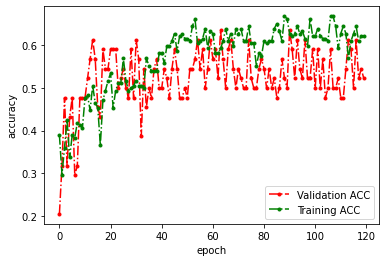

best validation result: 0.636364 at epoch 64


In [18]:
# figure
plt.plot(test_a,'r.-.', label = "Validation ACC")
plt.plot(train_a,'g.-.', label = "Training ACC")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()
print('best validation result: %f at epoch %d'% (np.amax(test_a), np.argmax(test_a)+1))

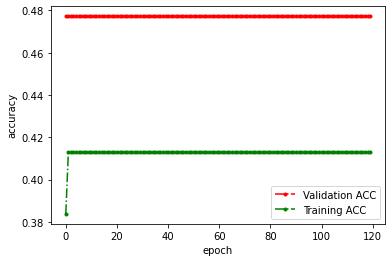

best validation result: 0.477273 at epoch 1


In [17]:
# figure
plt.plot(test_a,'r.-.', label = "Validation ACC")
plt.plot(train_a,'g.-.', label = "Training ACC")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()
print('best validation result: %f at epoch %d'% (np.amax(test_a), np.argmax(test_a)+1))